In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [6]:
df = pd.read_csv('results/master_file.csv', sep=';')

In [7]:
df.shape

(222314, 12)

In [8]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [9]:
df = df[df['Test Result'] != 'FAIL'].copy()

In [10]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Test Result
count,218267,218267,218267.000000,218267,218267.000000,218267.000000,218267.000000,218267.000000,218267
unique,41,4,NaN,218267,NaN,NaN,NaN,NaN,1
top,/g/user,POST,NaN,2023-04-03 15:14:23.030,NaN,NaN,NaN,NaN,PASS
freq,69933,104783,NaN,1,NaN,NaN,NaN,NaN,218267
mean,NaN,NaN,230.126148,NaN,630.299225,690.409068,112.383892,606.479569,NaN
std,NaN,NaN,72.204729,NaN,1878.687005,2823.852389,216.008094,1049.093612,NaN
min,NaN,NaN,200.000000,NaN,0.000000,2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,68.000000,72.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,120.000000,125.000000,36.000000,178.000000,NaN
75%,NaN,NaN,200.000000,NaN,439.000000,450.000000,83.000000,995.000000,NaN


In [11]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

# The average response time by endpoint

In [12]:
grouped = df.groupby('Endpoint')['Duration till body received[ms]'].mean()

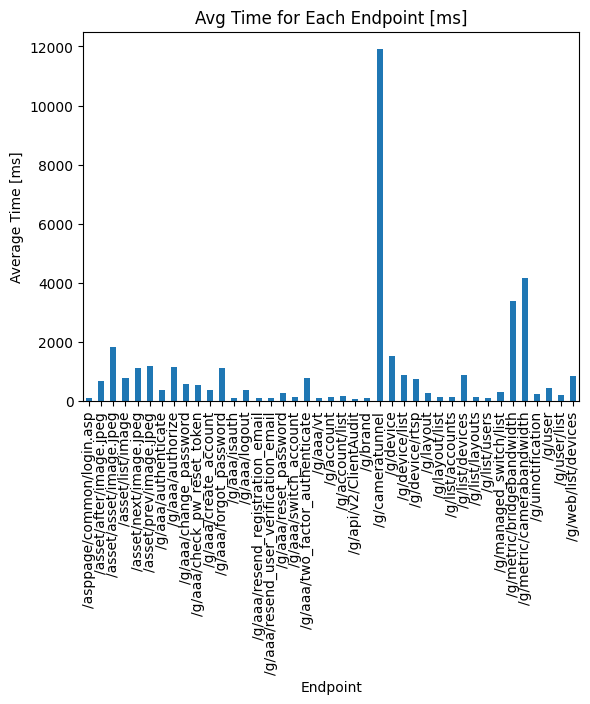

In [13]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Breakdown: average response time by endpoint compared to avg time today

In [16]:
import pandas as pd
from datetime import datetime, timedelta
import pytz


avg_duration = df.groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration = avg_duration.rename(columns={'Duration till body received[ms]': 'avg_duration'})

# get the average duration for the last 24 hours
#last_24_hours = datetime.now() - timedelta(hours=24)
last_24_hours = datetime.now(tz=pytz.timezone('US/Central')) - timedelta(hours=24)
avg_duration_last_24_hours = df[df['Start Time CST'] >= last_24_hours].groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration_last_24_hours = avg_duration_last_24_hours.rename(columns={'Duration till body received[ms]': 'avg_duration 24_hrs'})

# merge the two dataframes on the 'endpoints' column
result = pd.merge(avg_duration, avg_duration_last_24_hours, on='Endpoint', how='left')

# calculate percentage change
result['percentage_change'] = ((result['avg_duration 24_hrs'] - result['avg_duration']) / result['avg_duration']) * 100

result = result.round(0) # round to whole numbers
# print the result
print(result.to_string(index=False))

                             Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
            /asppage/common/login.asp         122.0                  NaN                NaN
              /asset/after/image.jpeg         696.0                188.0              -73.0
              /asset/asset/image.jpeg        1822.0               5052.0              177.0
                    /asset/list/image         777.0                625.0              -19.0
               /asset/next/image.jpeg        1111.0               2596.0              134.0
               /asset/prev/image.jpeg        1198.0               3264.0              173.0
                  /g/aaa/authenticate         377.0                484.0               28.0
                     /g/aaa/authorize        1163.0               1343.0               16.0
               /g/aaa/change_password         592.0                579.0               -2.0
          /g/aaa/check_pw_reset_token         550.0                658.0        

In [17]:
# filter rows with percentage_change greater than 20%
result_filtered = result[result['percentage_change'] > 20].sort_values('percentage_change', ascending=False)

# print the filtered result without index
print(result_filtered.to_string(index=False))

                 Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
    /g/aaa/reset_password         287.0               1488.0              419.0
    /g/aaa/create_account         366.0               1164.0              218.0
  /asset/asset/image.jpeg        1822.0               5052.0              177.0
   /asset/prev/image.jpeg        1198.0               3264.0              173.0
           /g/device/rtsp         763.0               2002.0              162.0
   /asset/next/image.jpeg        1111.0               2596.0              134.0
            /g/aaa/isauth         123.0                272.0              121.0
        /g/uinotification         238.0                445.0               87.0
                /g/aaa/vt         108.0                190.0               77.0
   /g/managed_switch/list         318.0                529.0               66.0
      /g/web/list/devices         865.0               1341.0               55.0
/g/metric/camerabandwidth        4181.0 

### Worst performaning endpoint all time

In [13]:
df_sorted = df.sort_values(by='Duration till body received[ms]', ascending=False)
df_sorted.iloc[0]

Endpoint                                     /g/metric/camerabandwidth
Method                                                             GET
Status Code                                                        200
Start time                                  2023-04-11 22:05:12.339000
Duration till headers received[ms]                              167193
Duration till body received[ms]                                 167197
Request Body Length                                                  0
Response Body Length                                              8899
Test Result                                                       PASS
Start Time CST                        2023-04-11 17:05:12.339000-05:00
Name: 13374, dtype: object

### Worst performaning endpoint last 24 hours

In [14]:
df_last_24_hrs = df[df['Start Time CST'] >= last_24_hours]
#print (df[df_huh['Duration till body received[ms]'].idxmax()])
df_last_24_hrs = df_last_24_hrs.sort_values(by='Duration till body received[ms]', ascending=False)
max_duration_row = df_last_24_hrs.iloc[0]
print (max_duration_row)

Endpoint                                                     /g/device
Method                                                             PUT
Status Code                                                        200
Start time                                  2023-04-26 05:42:50.747000
Duration till headers received[ms]                               61140
Duration till body received[ms]                                  61145
Request Body Length                                                118
Response Body Length                                                24
Test Result                                                       PASS
Start Time CST                        2023-04-26 00:42:50.747000-05:00
Name: 196867, dtype: object


## Median response time at each hour - all endpoints

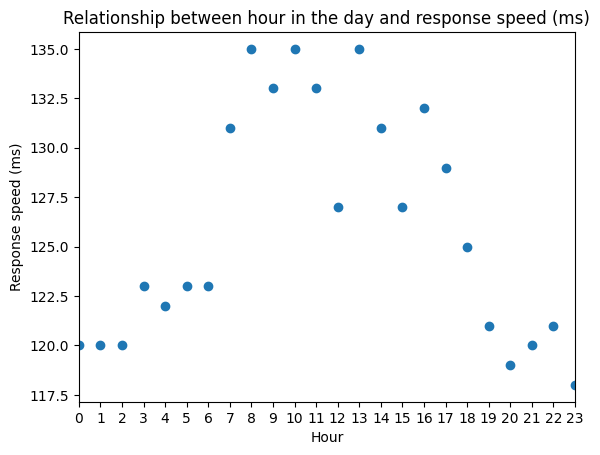

In [15]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Median response time at each day - all endpoints

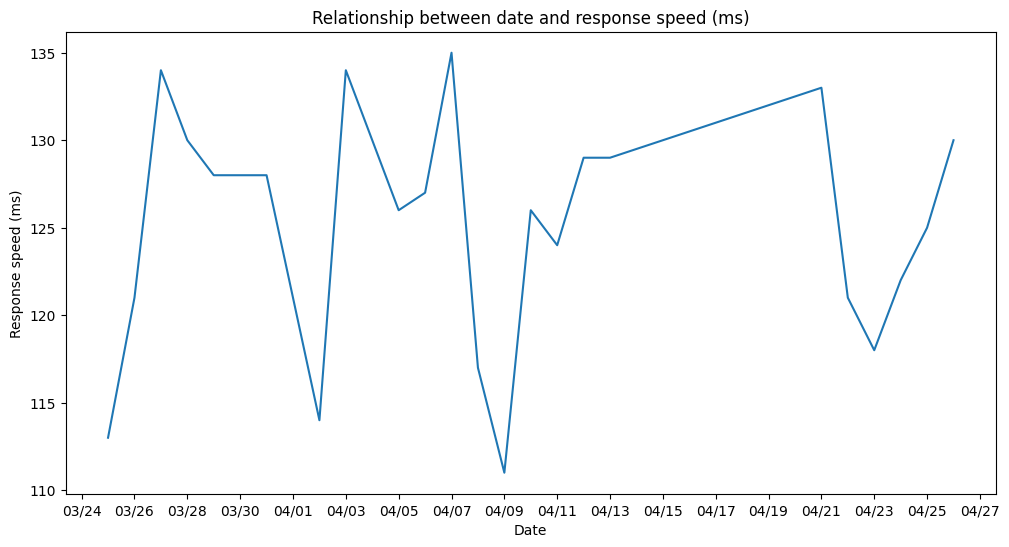

In [16]:
from matplotlib import dates as mpl_dates
import matplotlib.ticker as ticker


# Create a new column with the date value
df['Date'] = df['Start Time CST'].dt.date

# Calculate the mean duration for each day
daily_mean_duration = df.groupby('Date')['Duration till body received[ms]'].median()

# Create a new dataframe with all dates included
all_dates = pd.DataFrame({'Date': pd.date_range(start=df['Start Time CST'].min().date(), end=df['Start Time CST'].max().date())})

# Concatenate the daily mean duration data with the all-dates dataframe
result = pd.concat([all_dates.set_index('Date'), daily_mean_duration], axis=1, join='outer')

# Forward fill the missing values
result['Duration till body received[ms]'] = result['Duration till body received[ms]'].fillna(method='ffill')

# Build line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(result.index, result['Duration till body received[ms]'])
ax.set_xlabel('Date')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between date and response speed (ms)')

# Format the x-axis tick labels to display only the month and day
date_format = mpl_dates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))


plt.show()

## Speed throughout the day for endpoint - g/aaa/authenticate

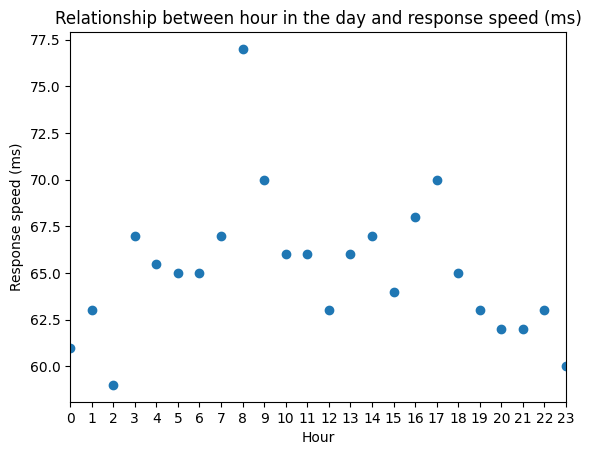

In [17]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

In [18]:
import datetime
import pytz
from datetime import datetime
import calendar

today = datetime.today()
weekday_name = calendar.day_name[today.weekday()]

# filter the dataframe to include only the data for Tuesdays
df_every_someday = df[df['Start Time CST'].dt.weekday == today.weekday()]

# filter the dataframe to include only the data for today
now = datetime.now(tz=pytz.timezone('US/Central'))
df_today = df[df['Start Time CST'].dt.date == now.date()]

# calculate the mean duration for each group (Endpoint column)
mean_duration_every_someday = df_every_someday['Duration till body received[ms]'].mean()
mean_duration_today = df_today['Duration till body received[ms]'].mean()

percentage_change = ((mean_duration_today - mean_duration_every_someday) / mean_duration_every_someday) * 100

print (f"Today's mean duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' mean duration: {mean_duration_every_someday:.2f} ms, Percentage change: {percentage_change:.2f}%")

Today's mean duration: 757.81 ms, Other Thursdays' mean duration: 720.69 ms, Percentage change: 5.15%


# The response length by endpoint

In [18]:
grouped = df.groupby('Endpoint')['Response Body Length'].mean()

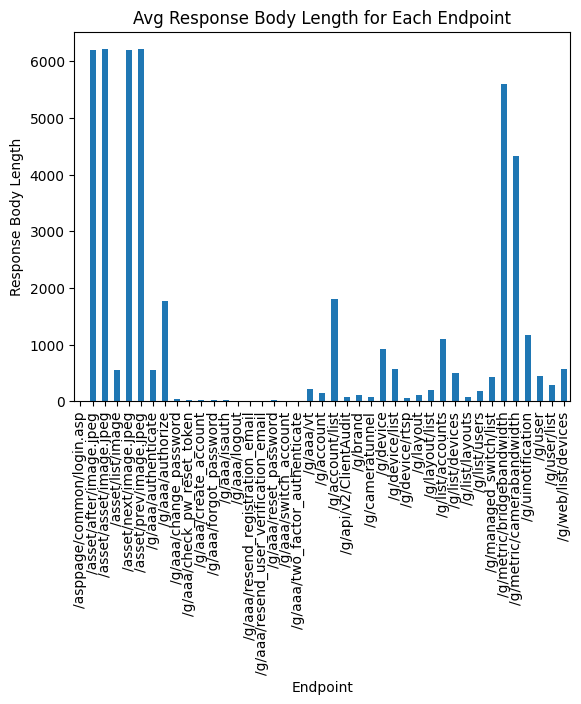

In [19]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

In [39]:
import os
from zulip_integration import Zulip
zu = Zulip()
zulip_msg =  f"Today's mean duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' mean duration: {mean_duration_every_someday:.2f} ms, Percentage change: {percentage_change:.2f}%"
#print (zulip_msg)
zulip_msg += "\nWORST PERFORMING ENDPOINTS TODAY:\n"
zulip_msg += result_filtered.to_string(index=False)
print (zulip_msg)
#zu.send_msg(zulip_msg)
print (type(result_filtered))
#for i in result_filtered:
#    print (i, result_filtered[i])
#print (zulip_msg("\nWORST PERFORMING ENDPOINTS TODAY:")
#print (result_filtered.to_string(index=False))
for index, row in result_filtered.iterrows():
    print("Row Endpoint! ", row[0], row.values )

Today's mean duration: 757.81 ms, Other Thursdays' mean duration: 720.69 ms, Percentage change: 5.15%
WORST PERFORMING ENDPOINTS TODAY:
                 Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
    /g/aaa/reset_password         287.0               1488.0              419.0
    /g/aaa/create_account         366.0               1164.0              218.0
  /asset/asset/image.jpeg        1822.0               5052.0              177.0
   /asset/prev/image.jpeg        1198.0               3264.0              173.0
           /g/device/rtsp         763.0               2002.0              162.0
   /asset/next/image.jpeg        1111.0               2596.0              134.0
            /g/aaa/isauth         123.0                272.0              121.0
        /g/uinotification         238.0                445.0               87.0
                /g/aaa/vt         108.0                190.0               77.0
   /g/managed_switch/list         318.0                529.0    